# Imports

In [15]:
import numpy as np
import torch
from torchvision import transforms as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

import sys
sys.path.append("..")

from data import pacs
import models.resnet_ms as resnet_ms

import utils

# Config

## Regarding Dataset

In [2]:
NUM_CLASSES = 7
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]

DOMAINS = ["sketch"]

## Hyperparameters

In [3]:
EPOCHS = 1  # More epochs for detailed sketch domain analysis
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
REGULARIZATION = 1e-3
MODEL = resnet_ms.resnet50_fc512_ms12_a0d1
USE_PRETRAINED = True
OPTIMIZER = optim.AdamW
OPTIMIZER_KWARGS = {
    "lr": LEARNING_RATE, # Standard value for AdamW: 1e-3
    "weight_decay": REGULARIZATION # Standard value for AdamW: 1e-2
}
SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau
SCHEDULER_KWARGS = {"mode": "min", "patience": 3}
EARLY_STOPPING_PATIENCE = 5
EARLY_STOPPING_DELTA = 1e-5
AUGMENTATIONS = ()
NUM_SEEDS = 1
verbosity = 1 # 1 for debugging, 0 for no debugging

## Image Normalization

In [4]:
# Values for pretrained ResNet
pretrained_image_transform = T.Compose([
    *AUGMENTATIONS,
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Device

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device: {device}")

Device: mps


## Abstract model building, optimizer and scheduler

In [6]:
build_model = lambda: MODEL(NUM_CLASSES, loss='softmax', pretrained=USE_PRETRAINED)
build_optimizer = lambda model: OPTIMIZER(model.parameters(), **OPTIMIZER_KWARGS)
build_scheduler = lambda optimizer: SCHEDULER(optimizer, **SCHEDULER_KWARGS)

# Set seed for reproducibility

In [7]:
# seed = 42
# torch.manual_seed(42)
# if device == torch.device("cuda"):
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# Training

In [8]:
writer = SummaryWriter()
%load_ext tensorboard
%tensorboard --logdir ./runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
/Users/max/Documents/domain_generalization/venv/lib/python3.13/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Traceback (most recent call last):
  File "/Users/max/Documents/domain_generalization/venv/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/Users/max/Documents/domain_generalization/venv/lib/python3.13/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/Users/max/Documents/domain_generalization/venv/lib/python3.13/site-packages/tensorboard/default.py", line 40, in <module>
    from tensorboard.plugins.image import images_plugin
  File "/Users/max/Documents/domain_

## Training Loop

In [9]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def accuracy(target, output):
    batch_size = target.shape[0]
    _, pred = torch.max(output, dim=-1)
    correct = pred.eq(target).sum()
    return correct.item() / batch_size

In [11]:
def train(epoch: int,
        target_domain: str,
        data_loader:torch.utils.data.DataLoader,
        model: nn.Module,
        optimizer: optim.Optimizer
        ) -> tuple[float, float]:
    """train one epoch"""
    model.train()
    losses = AverageMeter()
    accs = AverageMeter()


    
    for i, (data, target) in enumerate(data_loader):
        # Print progress every 20 batches for debugging
        if verbosity == 1 and i % 20 == 0 and i > 0:
            print(f"Batch {i+1}/{len(data_loader)}")
        
        step = (epoch - 1) * len(data_loader) + i + 1
        data = data.to(device)
        target = target.to(device)

        out = model(data)
        loss = F.cross_entropy(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = accuracy(target, out)
        losses.update(loss.item(), out.shape[0])
        accs.update(acc, out.shape[0])

        writer.add_scalar(f'Loss/Train/target={target_domain}', loss.item(), step)
        writer.add_scalar(f'Accuracy/Train/target={target_domain}', acc, step)

    return losses.avg, accs.avg

## Evaluation

In [12]:
def evaluate(data_loader: torch.utils.data.DataLoader, model: nn.Module, phase="val") -> tuple[float, float]:
    model.eval()

    losses = AverageMeter()
    accs = AverageMeter()

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)

            out = model(data)

            # The implementation returns only the feature vector rather than the classification logits.
            # To compare the labels, we therefore must apply the classification layer manually:
            out = model.classifier(out)

            loss = F.cross_entropy(out, target)
            acc = accuracy(target, out)

            losses.update(loss.item(), out.shape[0])
            accs.update(acc, out.shape[0])
    
    return losses.avg, accs.avg

## Training Loop

Starting training...


Seeds:   0%|          | 0/1 [00:00<?, ?it/s]

Target Domain:   0%|          | 0/1 [00:00<?, ?it/s]

Processing target domain: sketch
Insert MixStyle after the following layers: ['layer1', 'layer2']
Using pretrained normalization for sketch
Loading data for sketch...


Epoch (sketch):   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 1/1 for sketch. Training...
Batch 21/378
Batch 41/378
Batch 61/378
Batch 81/378
Batch 101/378
Batch 121/378
Batch 141/378
Batch 161/378
Batch 181/378
Batch 201/378
Batch 221/378
Batch 241/378
Batch 261/378
Batch 281/378
Batch 301/378
Batch 321/378
Batch 341/378
Batch 361/378
Training done in 141.13s - Loss: 1.0475, Acc: 0.7796
Creating visualization...


Extracting features:   0%|          | 0/245 [00:00<?, ?it/s]

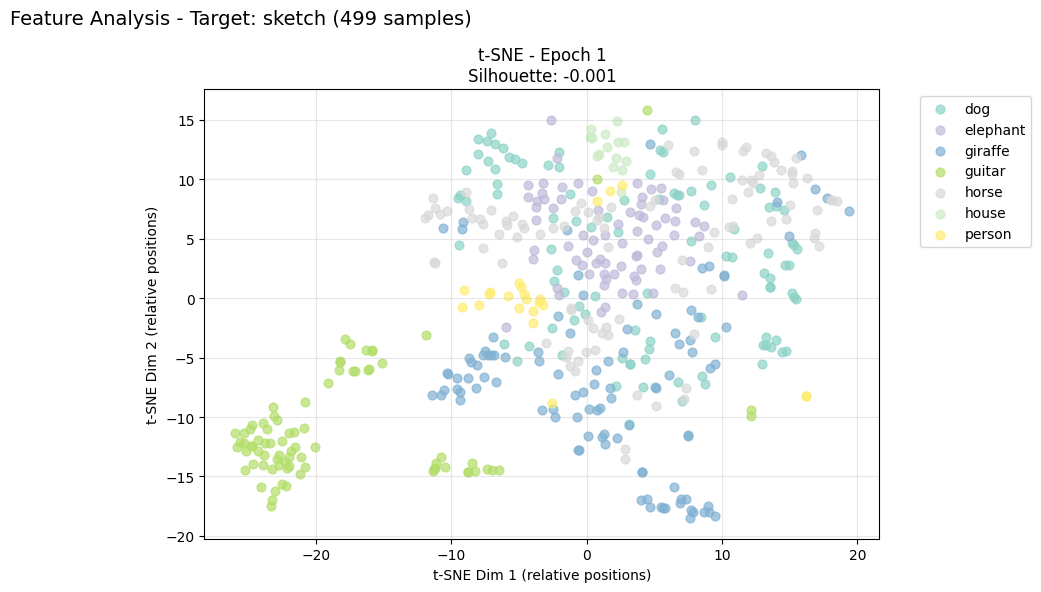

Saving best model (loss: 1.2327)

Training summary for sketch:
  Best test accuracy: 0.6842 (epoch 1)
  Final test accuracy: 0.6842
  Best test loss: 1.2327 (epoch 1)
  Final test loss: 1.2327
Loading best model for final evaluation...
Final accuracy for sketch: 0.6837
Average Accuracy:
	sketch: 0.6837, std: 0.0000
	total: 0.6837, std: 0.0000
Worst-case Accuracy:
	sketch: 0.6837
	total: 0.6837, std: 0.0000


In [13]:
all_results = {d: [] for d in DOMAINS}
all_results['avgs'] = []
all_results['worst'] = []

import time

if verbosity == 1:
    print(f"Starting training...")

for _ in tqdm(range(NUM_SEEDS), desc="Seeds"):
    results = {}

    for target_domain in tqdm(DOMAINS, desc="Target Domain"):
        if verbosity == 1:
            print(f"Processing target domain: {target_domain}")

        model = build_model()
        model = model.to(device)
        optimizer = build_optimizer(model)
        scheduler = build_scheduler(optimizer)

        if not USE_PRETRAINED:
            if verbosity == 1:
                print(f"Computing normalization stats for {target_domain}...")
            img_mean, img_std = pacs.get_normalization_stats(target_domain)
            if verbosity == 1:
                print(f"Normalization values excluding domain {target_domain}:\n\tmean: {img_mean}\n\tstd: {img_std}")
            image_transform = T.Compose([
                *AUGMENTATIONS,
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(mean=img_mean, std=img_std)
            ])
        else:
            image_transform = pretrained_image_transform
            if verbosity == 1:
                print(f"Using pretrained normalization for {target_domain}")

        if verbosity == 1:
            print(f"Loading data for {target_domain}...")
        train_loader, test_loader = pacs.get_data_loaders(target_domain, train_batch_size=BATCH_SIZE, transform=image_transform, shuffle_test=True, drop_last=True)


        best_loss = float('inf')
        patience_counter = 0

        feature_tracker = None
        epoch_results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
        
        for epoch in tqdm(range(1, EPOCHS + 1), desc=f"Epoch ({target_domain})"):
            if verbosity == 1:
                print(f"\nEpoch {epoch}/{EPOCHS} for {target_domain}. Training...")
            
            start_time = time.time()
            train_loss, train_acc = train(epoch, target_domain, train_loader, model, optimizer)
            train_time = time.time() - start_time
            if verbosity == 1:
                print(f"Training done in {train_time:.2f}s - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
            
            test_loss, test_acc = evaluate(test_loader, model)

            # store results
            epoch_results["train_loss"].append(train_loss)
            epoch_results["train_acc"].append(train_acc)
            epoch_results["test_loss"].append(test_loss)
            epoch_results["test_acc"].append(test_acc)

            writer.add_scalar(f"Loss/Test/target={target_domain}", test_loss, epoch)
            writer.add_scalar(f"Accuracy/Test/target={target_domain}", test_acc, epoch)

            scheduler.step(test_loss)

            # create visualization   max_samples set to 1500 due to RAM constraints
            if epoch % 1 == 0 or epoch == EPOCHS:
                if verbosity == 1:
                    print("Creating visualization...")
                feature_tracker = notebook_utils.track_feature_evolution(model, test_loader, epoch, target_domain, feature_tracker, visualize_every=1, max_samples=499, save_dir=f"../model_comparison/mixstyle/features/{target_domain}")


            if best_loss - test_loss < EARLY_STOPPING_DELTA and (patience_counter := patience_counter+1) > EARLY_STOPPING_PATIENCE:
                if verbosity == 1:
                    print(f"Early stopping triggered (patience: {patience_counter})")
                break

            if test_loss < best_loss:
                best_loss = test_loss
                best_acc = test_acc
                patience_counter = 0  # Reset patience counter when we improve
                print(f"Saving best model (loss: {best_loss:.4f})")
                torch.save(model.state_dict(), f"../checkpoints/mixstyle/best_{target_domain}.pt")
        
        if verbosity == 1:
            print(f"\nTraining summary for {target_domain}:")
            print(f"  Best test accuracy: {max(epoch_results['test_acc']):.4f} (epoch {np.argmax(epoch_results['test_acc'])+1})")
            print(f"  Final test accuracy: {epoch_results['test_acc'][-1]:.4f}")
            print(f"  Best test loss: {min(epoch_results['test_loss']):.4f} (epoch {np.argmin(epoch_results['test_loss'])+1})")
            print(f"  Final test loss: {epoch_results['test_loss'][-1]:.4f}")

            print("Loading best model for final evaluation...")
            model.load_state_dict(torch.load(f"../checkpoints/mixstyle/best_{target_domain}.pt"))
            _, acc = evaluate(test_loader, model, phase="final")
            print(f"Final accuracy for {target_domain}: {acc:.4f}")

        results[target_domain] = acc

    avg_acc = np.mean([*results.values()])
    worst_case_acc = np.min([*results.values()])

    for d in DOMAINS:
        all_results[d].append(results[d])
    all_results['avgs'].append(avg_acc)
    all_results['worst'].append(worst_case_acc)


print("Average Accuracy:\n" +
      "{}".format("".join(f"\t{d}: {np.mean(all_results[d]):.4f}, std: {np.std(all_results[d]):.4f}\n" for d in DOMAINS)) +
      f"\ttotal: {np.mean(all_results['avgs']):.4f}, std: {np.std(all_results['avgs']):.4f}\n"
      "Worst-case Accuracy:\n" +
      "{}".format("".join(f"\t{d}: {np.min(all_results[d]):.4f}\n" for d in DOMAINS)) +
      f"\ttotal: {np.mean(all_results['worst']):.4f}, std: {np.std(all_results['worst']):.4f}"
)

Additional plots

In [14]:
""" import matplotlib.pyplot as plt

# Create training curve plots
if len(all_results['sketch']) > 0 and 'epoch_results' in locals():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(epoch_results['train_loss']) + 1)
    
    # Loss curves
    ax1.plot(epochs, epoch_results['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, epoch_results['test_loss'], 'r-', label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training vs Test Loss (Sketch Domain)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2.plot(epochs, epoch_results['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, epoch_results['test_acc'], 'r-', label='Test Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training vs Test Accuracy (Sketch Domain)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Loss over epochs
    ax3.plot(epochs, epoch_results['test_loss'], 'g-', linewidth=2)
    ax3.axhline(y=min(epoch_results['test_loss']), color='r', linestyle='--', alpha=0.7, label=f'Best: {min(epoch_results["test_loss"]):.4f}')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Test Loss')
    ax3.set_title('Test Loss Progress (Sketch Domain)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Accuracy over epochs
    ax4.plot(epochs, epoch_results['test_acc'], 'purple', linewidth=2)
    ax4.axhline(y=max(epoch_results['test_acc']), color='r', linestyle='--', alpha=0.7, label=f'Best: {max(epoch_results["test_acc"]):.4f}')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Test Accuracy')
    ax4.set_title('Test Accuracy Progress (Sketch Domain)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../model_comparison/mixstyle/sketch_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show() """

' import matplotlib.pyplot as plt\n\n# Create training curve plots\nif len(all_results[\'sketch\']) > 0 and \'epoch_results\' in locals():\n    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))\n\n    epochs = range(1, len(epoch_results[\'train_loss\']) + 1)\n\n    # Loss curves\n    ax1.plot(epochs, epoch_results[\'train_loss\'], \'b-\', label=\'Training Loss\', linewidth=2)\n    ax1.plot(epochs, epoch_results[\'test_loss\'], \'r-\', label=\'Test Loss\', linewidth=2)\n    ax1.set_xlabel(\'Epoch\')\n    ax1.set_ylabel(\'Loss\')\n    ax1.set_title(\'Training vs Test Loss (Sketch Domain)\')\n    ax1.legend()\n    ax1.grid(True, alpha=0.3)\n\n    # Accuracy curves\n    ax2.plot(epochs, epoch_results[\'train_acc\'], \'b-\', label=\'Training Accuracy\', linewidth=2)\n    ax2.plot(epochs, epoch_results[\'test_acc\'], \'r-\', label=\'Test Accuracy\', linewidth=2)\n    ax2.set_xlabel(\'Epoch\')\n    ax2.set_ylabel(\'Accuracy\')\n    ax2.set_title(\'Training vs Test Accuracy 